In [166]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
with open('raw.chartblock.json') as f:
    json_str = f.read()

In [167]:
data = pd.read_json(json_str)

In [168]:
data.ticks[0][0:5]

[[1613480802018319, 0.056936999999999995],
 [1613480802106023, 0.056935],
 [1613480802191776, 0.056935],
 [1613480802277234, 0.056935],
 [1613480802367687, 0.056935]]

In [169]:
data

,id,name,ticks,timeSpan
0,e60e8371-1037-56d1-8859-5b353ff9cb2e,bid,"[[1613480802018319, 0.056936999999999995], [16...",3600000000
1,9a13bcd4-695c-59a4-8713-e642721ef97d,ask,"[[1613480802018319, 0.056939], [16134808021060...",3600000000


Мы будем пользоваться целыми числами для избежания ошибок округления. Для этого все цены увеличим в $10^6$ раз.

In [170]:
for i in data.ticks[0]:
    i[1] *= 10**6
    i[1] = round(i[1])

In [171]:
for i in data.ticks[1]:
    i[1] *= 10**6
    i[1] = round(i[1])

In [172]:
bid = np.array(data.ticks[0])
ask = np.array(data.ticks[1])

In [173]:
bid = bid[:, 1]
ask = ask[:, 1]

In [174]:
bid[0:5]

array([56937, 56935, 56935, 56935, 56935])

In [175]:
ask[0:5]

array([56939, 56939, 56939, 56939, 56939])

Посмотрим на спред

In [176]:
spread = ask - bid

In [177]:
print(spread.mean())
print(np.median(spread))

10.99479648762915
8.0


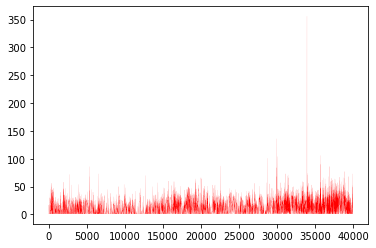

In [179]:
plt.plot(spread, color='red', linewidth=0.07)

Теперь напишем алгоритм для торговли.

In [193]:
def algo(money, bid, ask):
    """
    money - start money
    bid - array of bid price * 10^6
    ask - array of ask price * 10^6
    """
    num_of_stocks = 0
    num_of_purchased = 0
    prev_ask_price = 0 # ask price at last purchase
    for i in range(len(bid) - 1):
        if ask[i] < bid[i + 1] and ask[i] <= money:
            prev_ask_price = ask[i]
            num_of_stocks += money // ask[i]
            num_of_purchased += money // ask[i]
            money = money % ask[i] # buy stocks as much as I can
        elif bid[i] > bid[i + 1] and bid[i] > prev_ask_price and num_of_stocks != 0:
            money += bid[i] * num_of_stocks
            num_of_stocks = 0 # sell stocks as much as I can
    i = -1
    money += bid[i] * num_of_stocks
    num_of_stocks = 0 # sell stocks as much as I can
    return money, num_of_stocks, num_of_purchased

Алгоритм работает так:
1) Если мы можем купить сейчай, а продать на следующей итерации с профитом, то мы покупаем акций на всю сумму. (но не обязательно мы их продадим на след. итерации)

2) Если мы можем продать акции с выгодой, при этом мы находимся в локальном максимуме bid'а, то мы продаем.

3) На последней итерации продаем оставшиеся акции.

In [202]:
x, y, z = algo(10**6, bid, ask)

In [204]:
print(x, y, z, sep='\n')

1271917
0
12444


In [201]:
(x/10**6 - 1) * 100

27.191699999999997

Прибыль составила 27 процентов.